In [37]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
import requests
import alpaca_trade_api as tradeapi
import os
from pathlib import Path
from dotenv import load_dotenv


%matplotlib inline

In [38]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [41]:

load_dotenv()

#path='Users\costa\Desktop\Byte\rice\ru-hou-fin-pt-03-2020-u-c\hw\05-APIs\Instructions\Starter_Code\.env'

#load_dotenv(dotenv_path=path,verbose=True)

APCA_API_KEY_ID = os.getenv("APCA_API_KEY_ID")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

type(APCA_API_KEY_ID)
print(APCA_API_KEY_ID)

#did not load




None


# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [75]:
list_of_tickers = ["SPY", "AGG"]

#Since I could not pull key out of env file, I had to make them variables here

APCA_API_KEY_ID ='PK4VGJ0U6ZCKD9BBDD5Z' 
APCA_SECRET_KEY ='iNQzNiVczS5vWr9KTM9d4xiAGFK1OglhmhynXO2h'
 

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')

# Get daily price data for SPY over the last 1000 trading days. Max alpaca would allow.
#download direct into dataframe

barset = api.get_barset('SPY', 'day', limit=1000).df
spy_bars_df = barset['SPY']
#spy_bars_df.head()
#spy_bars_df.tail()

# Get daily price data for AGG over the last 1000 trading days. Max alpaca would allow.

barset = api.get_barset('AGG', 'day', limit=1000).df
agg_bars_df = barset['AGG']
#agg_bars_df.head()
#agg_bars_df.tail()


#Clean up data, drop extraneous columns

spy_bars_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
agg_bars_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)


# Keep date, remove time
spy_bars_df.index = spy_bars_df.index.date
agg_bars_df.index = agg_bars_df.index.date

#spy_bars_df.tail()
#agg_bars_df.head()

concat_df = pd.concat([spy_bars_df, agg_bars_df], axis = "columns", join = "inner")

concat_df.head()

#change column names to avoid confusion
columns = ['spy close', 'agg close']
concat_df.columns = columns
concat_df.head()

#add another column to get daily returns of SPY
daily_returns_spy = spy_bars_df.pct_change()
concat_df['spy_return']= daily_returns_spy 


#add another column to get daily returns for AGG
daily_returns_agg = agg_bars_df.pct_change()
concat_df['agg_return']= daily_returns_agg 
concat_df.head()

#add another column to get 60/40 returns
concat_df['60-40 returns'] = (concat_df.spy_return * .60)+(concat_df.agg_return * .40)

concat_df.head()


,spy close,agg close,spy_return,agg_return,60-40 returns
2016-04-21,208.96,110.510,NaN,NaN,NaN
2016-04-22,208.99,110.540,0.000144,0.000271,0.000195
2016-04-25,208.61,110.390,-0.001818,-0.001357,-0.001634
2016-04-26,208.97,110.345,0.001726,-0.000408,0.000872
2016-04-27,209.34,110.650,0.001771,0.002764,0.002168


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [86]:
# Calculate the daily roi for SPY
daily_returns_spy = spy_bars_df.pct_change()
daily_returns_spy.head()

## Calculate the daily roi for AGG
daily_returns_agg = agg_bars_df.pct_change()
daily_returns_agg.head()


,close
2016-04-21,NaN
2016-04-22,0.000271
2016-04-25,-0.001357
2016-04-26,-0.000408
2016-04-27,0.002764


In [87]:
# Calculate volatility of SPY

std_dev_daily_returns_spy = daily_returns_spy.std()['close']
print(std_dev_daily_returns_spy)

# Calculate volatility of AGG

std_dev_daily_returns_agg = daily_returns_agg.std()['close']
print(std_dev_daily_returns_agg)

0.012033630299577065
0.003224720275429531


In [88]:
# Use the `mean` function to calculate the mean of daily returns for `spy` and `agg`, respectively
avg_daily_return_spy = daily_returns_spy.mean()['close']
avg_daily_return_agg = daily_returns_agg.mean()['close']
avg_daily_return_agg

6.32977223616645e-05

In [89]:
# Save the last day's closing price
last_day_closing_spy = spy_bars_df['close'][-1]
last_day_closing_agg = agg_bars_df['close'][-1]

print(last_day_closing_spy)
print(last_day_closing_agg)

278.24
117.11


In [90]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()


In [91]:
# Run the Monte Carlo Simulation 500 times
for x in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [last_day_closing_spy]
    simulated_agg_prices = [last_day_closing_agg]
    
    # Simulate the returns for 30 years
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_returns_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_returns_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% SPY)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993627,0.999113,1.005244,0.995334,0.998033,1.008541,1.010134,1.010636,0.996342,0.996128,...,1.008573,0.995470,0.994181,1.001588,1.019898,1.002389,0.994930,0.995158,0.996305,0.998326
2,0.990002,0.995823,1.016369,0.994729,0.992747,1.009860,1.027741,1.010309,0.987780,0.992667,...,1.018602,0.988096,1.001176,1.000144,1.021231,1.008133,1.003394,0.997399,0.995977,0.991381
3,0.988407,0.992404,1.015996,0.999137,0.998133,1.006802,1.037420,1.011270,0.984348,0.987776,...,1.025865,0.984806,0.991892,1.012116,1.026077,1.004588,1.008869,0.998507,0.997116,0.991622
4,0.996050,1.001655,1.015478,1.009882,0.998752,1.011751,1.040588,1.008305,0.989431,0.999553,...,1.025637,0.980009,0.991007,1.010309,1.026647,1.000007,0.995771,0.993787,1.007356,0.989891


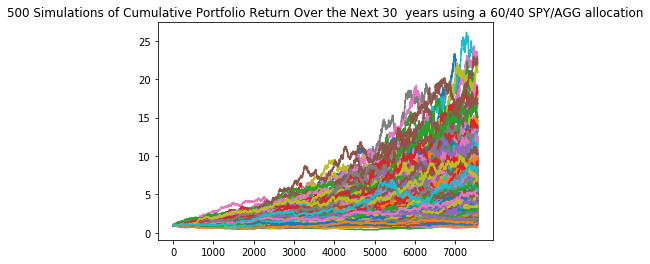

In [94]:
# Visualize the Simulation
# Use the `plot` function to plot `500` simulations of the potential trajectories of the portfolio based on 30 years
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Over the Next 30  years using a 60/40 SPY/AGG allocation"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [95]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
 
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0     8.953317
1     8.114615
2     6.077282
3     4.999049
4    10.120049
Name: 7560, dtype: float64

In [96]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-2520, :]
ending_cumulative_returns.head()

0    8.629977
1    3.623425
2    2.864994
3    5.764251
4    4.341965
Name: 5041, dtype: float64

In [97]:
# Display the 90% confidence interval for the ending returns

confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    1.279978
0.95    6.682616
Name: 5041, dtype: float64

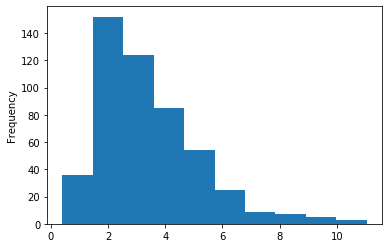

In [98]:
#Visualize the distribution of the ending returns

ending_cumulative_returns.plot(kind='hist', bins=10)

In [99]:
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(1.47, 2.534]     0.304
(2.534, 3.598]    0.248
(3.598, 4.663]    0.170
(4.663, 5.727]    0.108
(0.393, 1.47]     0.072
(5.727, 6.792]    0.050
(6.792, 7.856]    0.018
(7.856, 8.921]    0.014
(8.921, 9.985]    0.010
(9.985, 11.05]    0.006
Name: 5041, dtype: float64

6.682615520494301
1.2799776839775643


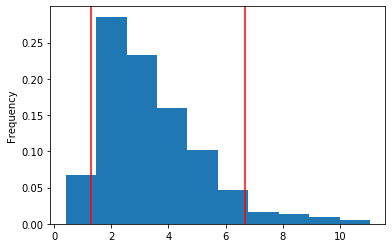

In [116]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 90% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')
print(confidence_interval.iloc[1])
print(confidence_interval.iloc[0])

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [101]:


# Display the 10% confidence interval for the ending returns

confidence_interval_10 = ending_cumulative_returns.quantile(q=[0.45, 0.55])
print(confidence_interval_10)

# Display the 50% confidence interval for the ending returns

confidence_interval_50 = ending_cumulative_returns.quantile(q=[0.25, 0.75])
print(confidence_interval_50)

# Display the 90% confidence interval for the ending returns

confidence_interval_90 = ending_cumulative_returns.quantile(q=[0.05, 0.95])
print(confidence_interval_90)



0.45    2.849741
0.55    3.212413
Name: 5041, dtype: float64
0.25    2.144470
0.75    4.339769
Name: 5041, dtype: float64
0.05    1.279978
0.95    6.682616
Name: 5041, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [106]:

# Set initial investment for 10% confidence interval

initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[1])
                                                    
# Print the results
print(f"There is a 10% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")



# Set initial investment for 50% confidence interval

initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_50.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval_50.iloc[1])
                                                    
# Print the results
print()
print(f"There is a 50% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")


# Set initial investment for 90% confidence interval

initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_90.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval_90.iloc[1])
                                                    
# Print the results
print()
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 10% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $76994.82050097422 and $84248.25071134341

There is a 50% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $62889.391010638 and $106795.38935282438

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $45599.55367955129 and $153652.31040988603


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [109]:

projected_annual_income = 6085
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[0])
withdrawal_rate = .04

if (investment_pnl_lower_bound * withdrawal_rate)>= projected_annual_income:
    print("Great! You will have enough funds at retirement to replace your income at retirement.")
else:
    print("Oops! Tighten your belt, there's a chance you will not be able to replace your income at retirement.")

print(projected_annual_income)
print(investment_pnl_lower_bound * withdrawal_rate)


Oops! Tighten your belt, there's a 10% chance you will not be able to replace your income at retirement.
6085
3079.792820038969


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [113]:
# Set initial investment for 10% confidence interval

initial_investment = 30000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[0])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[1])
                                                    
# Print the results
print(f"There is a 10% chance that an initial investment of $30,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

projected_annual_income = 6085
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval_10.iloc[0])
withdrawal_rate = .04
print()

if (investment_pnl_lower_bound * withdrawal_rate)>= projected_annual_income:
    print("Great! You will have enough funds at retirement to replace your income at retirement.")
else:
    print("Oops! Tighten your belt, there's a chance you will not be able to replace your income at retirement.")

print(projected_annual_income)
print(investment_pnl_lower_bound * withdrawal_rate)


There is a 10% chance that an initial investment of $30,000 in the portfolio over the next 30 years will end within in the range of $115492.23075146135 and $126372.37606701512

Oops! Tighten your belt, there's a chance you will not be able to replace your income at retirement.
6085
4619.689230058454


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# 